In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt

import sklearn.preprocessing as skp
import sklearn.model_selection as skms
import sklearn.feature_extraction.text as sktext
import sklearn.linear_model as sklm

from nltk.tokenize import  RegexpTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer

In [ ]:
x1 = "Estoy de acuerdo. Su propuesta es buena. "
x2 = "No estoy de acuerdo con la propuesta no importa cuanto lo repita"
x3 = "Su propuesta es buena"
x4 = "Su propuesta es clara!"

y1 = "Positivo"
y2 = "Negativo"
y3 = "Positivo"
y4 = "Negativo"

x = [x1,x2,x3,x4]
y = [y1,y2,y3,y4]

In [ ]:
vocabulario= set(
    (x1+" "+x2+" "+x3+" "+x4).lower().replace(".","").replace("!","").split()
)
print(len(vocabulario))
print(sorted(vocabulario))

15
['acuerdo', 'buena', 'clara', 'con', 'cuanto', 'de', 'es', 'estoy', 'importa', 'la', 'lo', 'no', 'propuesta', 'repita', 'su']


In [ ]:
xt = pd.DataFrame(
    np.zeros((4,len(vocabulario)), dtype=int), columns=sorted(vocabulario),
    index=x
)
xt

,acuerdo,buena,clara,con,cuanto,de,es,estoy,importa,la,lo,no,propuesta,repita,su
Estoy de acuerdo. Su propuesta es buena.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
No estoy de acuerdo con la propuesta no importa cuanto lo repita,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Su propuesta es buena,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Su propuesta es clara!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
for i,s in enumerate(x):
  for t in s.lower().replace(".","").replace("!","").split():
    xt.loc[x[i],t]+=1
xt

,acuerdo,buena,clara,con,cuanto,de,es,estoy,importa,la,lo,no,propuesta,repita,su
Estoy de acuerdo. Su propuesta es buena.,1,1,0,0,0,1,1,1,0,0,0,0,1,0,1
No estoy de acuerdo con la propuesta no importa cuanto lo repita,1,0,0,1,1,1,0,1,1,1,1,2,1,1,0
Su propuesta es buena,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1
Su propuesta es clara!,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1


In [ ]:
#usando la libreria, se forma la misma matriz que con pandas
xencoder = sktext.CountVectorizer(lowercase=True)
xencoder.fit_transform(x).todense()

matrix([[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]])

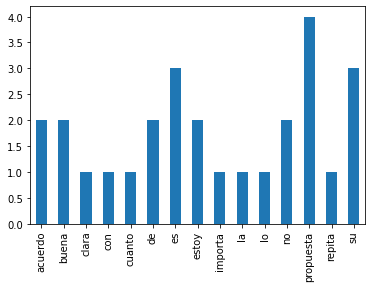

In [ ]:
xt.sum().plot(kind="bar")

In [ ]:
yencoder = skp.LabelEncoder() #codificar las palabras
yencoder.fit_transform(y)

array([1, 0, 1, 0])

In [ ]:
yencoder.inverse_transform([0,1])

array(['Negativo', 'Positivo'], dtype='<U8')

#Ejemplo: Analisis de entimiento

In [ ]:
!wget lalussoft.com/mldemos/tweets1.xls

--2021-07-12 20:33:25--  http://lalussoft.com/mldemos/tweets1.xls
Resolving lalussoft.com (lalussoft.com)... 34.198.109.148
Connecting to lalussoft.com (lalussoft.com)|34.198.109.148|:80... connected.
HTTP request sent, awaiting response... 302 Redirect
Location: https://lalussoft.com/mldemos/tweets1.xls [following]
--2021-07-12 20:33:25--  https://lalussoft.com/mldemos/tweets1.xls
Connecting to lalussoft.com (lalussoft.com)|34.198.109.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 917504 (896K) [application/vnd.ms-excel]
Saving to: ‘tweets1.xls’

tweets1.xls         100%[===================>] 896.00K  2.85MB/s    in 0.3s    

2021-07-12 20:33:26 (2.85 MB/s) - ‘tweets1.xls’ saved [917504/917504]



In [ ]:
tweets = pd.read_excel("tweets1.xls")
tweets

,tweet,class
0,abcdesevilla.es: Recio no tiene «indicios pote...,neg
1,abcdesevilla.es: Cuatro altos cargos de Empleo...,neg
2,La marcha atrás del PP en posponer devolución ...,neg
3,Accidente en BUS-VAO A-6 km. 12. Motorista de ...,neg
4,"#FF a ti, que deseas desesperadamente hacerme ...",neg
...,...,...
5061,Aguirre partidaria de q el Estado asuma Sanid...,pos
5062,A ambas cosas yo le llamo redistribución d riq...,pos
5063,Ya somos dos ;-)) q ganas de verte RT @adelaut...,pos
5064,Nace una jirafa en el @zoomadrid la primera d...,pos


In [ ]:
from pandas.core.common import random_state
xtrain, xtest, ytrain, ytest = skms.train_test_split(tweets["tweet"], tweets["class"], test_size=0.3, random_state=0)

Primero lo hacemos sin pre procesamiento

In [ ]:
xencoder = sktext.CountVectorizer()
xencoder.fit_transform(xtrain)

<3546x13351 sparse matrix of type '<class 'numpy.int64'>'
	with 54683 stored elements in Compressed Sparse Row format>

In [ ]:
yencoder = skp.LabelEncoder()
yencoder.fit_transform(ytrain)

array([0, 0, 1, ..., 0, 1, 1])

In [ ]:
modelo = sklm.LogisticRegression(random_state = 0)
modelo.fit(xencoder.transform(xtrain), yencoder.transform(ytrain))
modelo.score(xencoder.transform(xtest), yencoder.transform(ytest))

0.7881578947368421

Ahora Con preprocesamiento

In [ ]:
tokenizer = TweetTokenizer()
Stemmer = SnowballStemmer(language="spanish")
usar_stemmer = 0
def TokenizarTweet(s):
  #eliminamos la URL
  s = re.sub(r"(http://|https://)[\w\d_-]+(\.[\w\d_-])*\.\w{2,}(/[\w\d\_+#.-]+)*","",s)

  #eliminar hashtag
  s = re.sub(r"#[\w\dáéíóúÁÉÍÓÚñ_]+", "",s)

  #eliminar @xx
  s = re.sub(r"@[\w\dáéíóúÁÉÍÓÚñ_]+", "",s)

  #eliminar otros
  s = re.sub(r"[¡]", "",s)
  s = re.sub(r"[¿]", "",s)

  #uniformizar cantidades
  s = re.sub(r"\s\d+[.]?\d+|\s[.]\d+","CANTIDAD",s)
  s = re.sub(r"\s\d+([,]\d+)?","CANTIDAD",s)

  #otras expresiones no relevantes
  s = s.replace("»", " ")
  s = s.replace("«", " ")
  s = s.replace("\"", " ")

  tokens = tokenizer.tokenize(s)

  #aplicar stop words
  stop_list = ["a", "e", "i", "o", "u", "y", "en", "la", "al", "un", "una", "de", "el", "le",
               "su", "los", ".", ",", "*", "(", ")", "&"]
  tokens = [token for token in tokens if token not in stop_list]
  if usar_stemmer==1:
    tokens = [Stemmer.stem(token) for token in tokens]
  return tokens

In [ ]:
xencoder = sktext.CountVectorizer(lowercase=True, tokenizer=TokenizarTweet)
xencoder.fit_transform(xtrain)

<3546x10995 sparse matrix of type '<class 'numpy.int64'>'
	with 44395 stored elements in Compressed Sparse Row format>

In [ ]:
modelo = sklm.LogisticRegression(random_state=0)
modelo.fit(xencoder.transform(xtrain), yencoder.transform(ytrain))
modelo.score(xencoder.transform(xtest), yencoder.transform(ytest))

0.7875

In [ ]:
#probando el modelo
yencoder.inverse_transform(
    modelo.predict(
        xencoder.transform(["No me parece que su actitud sea la correcta"])
    )
)

array(['neg'], dtype=object)

In [ ]:
modelo.predict_proba(
    xencoder.transform(["No me parece que su actitud sea la correcta"])
)

array([[0.63037704, 0.36962296]])

In [ ]:
def analizador(modelo,xencoder,yencoder,tweet):
  yt = modelo.predict(xencoder.transform([tweet]))
  y = yencoder.inverse_transform(yt)
  yprob = modelo.predict_proba(xencoder.transform([tweet]))
  return "Clase: {}, con {:.2f}% de probabilidad".format(y[0],yprob[0][yt][0]*100)

In [ ]:
analizador(modelo,xencoder,yencoder,"No me parece que su actitud sea la correcta")

'Clase: neg, con 63.04% de probabilidad'

In [ ]:
def test_analizador(modelo, xencoder, yencoder):
  pruebas = [
             "No me parece quesu actitud sea la correcta",
             "su actitud es la correcta",
             "su actituy es muy correcta",
             "no creo que su actitud sea mala",
             ":-)"
  ]
  for p in pruebas:
    print(p, "->", analizador(modelo,xencoder,yencoder, p))

In [ ]:
test_analizador(modelo, xencoder, yencoder)

No me parece quesu actitud sea la correcta -> Clase: neg, con 61.91% de probabilidad
su actitud es la correcta -> Clase: pos, con 50.65% de probabilidad
su actituy es muy correcta -> Clase: pos, con 73.97% de probabilidad
no creo que su actitud sea mala -> Clase: neg, con 76.91% de probabilidad
:-) -> Clase: pos, con 85.56% de probabilidad


#N-gramas

In [ ]:
x = ["no va a demorar", "va a demorar"]
xencoder = sktext.CountVectorizer(ngram_range = (1,2), token_pattern=r"\w+")
pd.DataFrame(
    xencoder.fit_transform(x).todense(),
  columns=xencoder.get_feature_names(),
  index=x
)


,a,a demorar,demorar,no,no va,va,va a
no va a demorar,1,1,1,1,1,1,1
va a demorar,1,1,1,0,0,1,1


In [ ]:
xencoder = sktext.CountVectorizer(tokenizer=TokenizarTweet, ngram_range=(1,2), token_pattern=None)
xencoder.fit(xtrain)
modelo = sklm.LogisticRegression(random_state=0)
modelo.fit(xencoder.transform(xtrain), yencoder.transform(ytrain))
modelo.score(xencoder.transform(xtest), yencoder.transform(ytest))

0.7907894736842105

In [ ]:
test_analizador(modelo, xencoder, yencoder)

No me parece quesu actitud sea la correcta -> Clase: neg, con 62.27% de probabilidad
su actitud es la correcta -> Clase: pos, con 53.10% de probabilidad
su actituy es muy correcta -> Clase: pos, con 76.34% de probabilidad
no creo que su actitud sea mala -> Clase: neg, con 83.18% de probabilidad
:-) -> Clase: pos, con 81.78% de probabilidad


In [ ]:
usar_stemmer=1
xencoder = sktext.CountVectorizer(tokenizer=TokenizarTweet, ngram_range=(1,2), token_pattern=None)
xencoder.fit(xtrain)
modelo = sklm.LogisticRegression(random_state=0)
modelo.fit(xencoder.transform(xtrain), yencoder.transform(ytrain))
modelo.score(xencoder.transform(xtest), yencoder.transform(ytest))

0.7967105263157894

In [ ]:
xencoder = sktext.CountVectorizer(tokenizer=TokenizarTweet, token_pattern=None)
xencoder.fit_transform(xtrain)

<3546x7146 sparse matrix of type '<class 'numpy.int64'>'
	with 44173 stored elements in Compressed Sparse Row format>

In [ ]:
test_analizador(modelo, xencoder, yencoder)

No me parece quesu actitud sea la correcta -> Clase: neg, con 56.89% de probabilidad
su actitud es la correcta -> Clase: pos, con 57.02% de probabilidad
su actituy es muy correcta -> Clase: pos, con 78.27% de probabilidad
no creo que su actitud sea mala -> Clase: neg, con 91.42% de probabilidad
:-) -> Clase: pos, con 81.35% de probabilidad


# Tokens a nivel de caracter

In [ ]:
x = ["como demora", "no demora"]
xencoder = sktext.CountVectorizer(analyzer="char", ngram_range=(1,3))
pd.DataFrame(
    xencoder.fit_transform(x).todense(),
  columns=xencoder.get_feature_names(),
  index=x
)

,,d,de,a,c,co,com,d,de,dem,e,em,emo,m,mo,mo,mor,n,no,no,o,o,o d,om,omo,or,ora,r,ra
como demora,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,0,0,0,3,1,1,1,1,1,1,1,1
no demora,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,2,1,1,0,0,1,1,1,1


In [ ]:
usar_stemmer=1
xencoder = sktext.CountVectorizer(tokenizer=TokenizarTweet, ngram_range=(1,2), token_pattern=None)
xencoder.fit(xtrain)
modelo = sklm.LogisticRegression(random_state=0)
modelo.fit(xencoder.transform(xtrain), yencoder.transform(ytrain))
modelo.score(xencoder.transform(xtest), yencoder.transform(ytest))

0.7967105263157894

In [ ]:
test_analizador(modelo, xencoder, yencoder)

No me parece quesu actitud sea la correcta -> Clase: neg, con 56.89% de probabilidad
su actitud es la correcta -> Clase: pos, con 57.02% de probabilidad
su actituy es muy correcta -> Clase: pos, con 78.27% de probabilidad
no creo que su actitud sea mala -> Clase: neg, con 91.42% de probabilidad
:-) -> Clase: pos, con 81.35% de probabilidad


# TF- IDF

In [ ]:
x = ["como demora", "no demora"]
xencoder = sktext.TfidfVectorizer()
pd.DataFrame(
    xencoder.fit_transform(x).todense(),
  columns=xencoder.get_feature_names(),
  index=x
)

,como,demora,no
como demora,0.814802,0.579739,0.000000
no demora,0.000000,0.579739,0.814802


In [ ]:
xencoder =sktext.TfidfVectorizer(tokenizer=TokenizarTweet, token_pattern=None)
xencoder.fit(xtrain)
modelo = sklm.LogisticRegression(random_state=0)
modelo.fit(xencoder.transform(xtrain), yencoder.transform(ytrain))
modelo.score(xencoder.transform(xtest), yencoder.transform(ytest))

0.8046052631578947

In [ ]:
import sklearn.neural_network as sknn

In [ ]:
modelo = sknn.MLPClassifier(hidden_layer_sizes=(100,), random_state=0)
modelo.fit(xencoder.transform(xtrain), yencoder.transform(ytrain))
modelo.score(xencoder.transform(xtest), yencoder.transform(ytest))

0.7802631578947369

In [ ]:
modelo = sknn.MLPClassifier(hidden_layer_sizes=(100,100, 50), random_state=0)
modelo.fit(xencoder.transform(xtrain), yencoder.transform(ytrain))
modelo.score(xencoder.transform(xtest), yencoder.transform(ytest))

0.7736842105263158

In [ ]:
import sklearn.pipeline as skpipe

In [ ]:
pipe = skpipe.Pipeline(
    steps = [
             ("Codificar", sktext.TfidfVectorizer(tokenizer=TokenizarTweet, token_pattern=None)),
             ("Logistic Regression", sklm.LogisticRegression(random_state=0))
    ]
)

In [ ]:
pipe.fit(xtrain, yencoder.transform(ytrain))
pipe.score(xtest,yencoder.transform(ytest))

0.8046052631578947